In [11]:
import pandas as pd
import numpy as np
from collections import Counter 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
from tqdm import tqdm
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.feature_selection import f_regression
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import sys 

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src/abundance/')
from abundance_plots import AbundancePlotSettingsAndSave
from abundance_plots import abundance_plot_settings


BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
F_REGRESSION_RESULTS = BLOOD_MICROBIOME_DIR + 'results/f_regression/f_regression_results.csv'
BAM_MAPPINGS_FILE = BLOOD_MICROBIOME_DIR + 'data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)

MICROBE_FILE = BLOOD_MICROBIOME_DIR + 'data/kraken_align/microbe_filtered_species.tsv'
FIG_DIR = BLOOD_MICROBIOME_DIR + 'results/family_associations/'
df_microbe = pd.read_table(MICROBE_FILE, index_col=0).transpose()

In [16]:
f_regress_results = pd.read_csv(F_REGRESSION_RESULTS, header=None)
f_regress_results.drop(0, inplace=True, axis=1)
f_regress_results.columns = ['name', 'exog_value', 'coeff']
f_regress_results['coeff_abs'] = abs(f_regress_results.coeff)
f_regress_results = f_regress_results[f_regress_results.coeff>0]

In [17]:
# Microbes & viruses with no association w/sequencing plate.
set(df_microbe.columns).difference((set(f_regress_results[['sequencing_plate' in c for c in f_regress_results.exog_value]].name)))

{'Esparto virus',
 'Human betaherpesvirus 6A',
 'Human betaherpesvirus 6B',
 'Human betaherpesvirus 7',
 'Human erythrovirus V9',
 'Human mastadenovirus C',
 'Human respirovirus 3',
 'Lactococcus virus c2',
 'Macacine gammaherpesvirus 4',
 'Murine leukemia virus',
 'Murmansk microtuspox virus',
 'Mycoplasma sp. NEAQ87857',
 'Natronomonas sp. C90',
 'Nostoc sp. C052',
 'Pandoravirus macleodensis',
 'Primate erythroparvovirus 1',
 'Primate erythroparvovirus 3',
 'Pseudomonas tolaasii',
 'Squirrel monkey retrovirus',
 'Torque teno virus 13',
 'Torque teno virus 15',
 'Torque teno virus 20',
 'Torque teno virus 21',
 'Torque teno virus 24',
 'Torque teno virus 7',
 'Torque teno virus 8'}

In [23]:
family_microbes = set(f_regress_results[['family' in c for c in f_regress_results.exog_value]].name).difference(
    (set(f_regress_results[['sequencing_plate' in c for c in f_regress_results.exog_value]].name)))

In [22]:
# Read in data
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
df_microbe['sequencing_plate'] = bam_mappings.loc[[i.split(' ')[0] for i in df_microbe.index]].sequencing_plate.values
df_microbe['family'] = bam_mappings.loc[[i.split(' ')[0] for i in df_microbe.index]].family.values
df_microbe['bio_seq_source'] = bam_mappings.loc[[i.split(' ')[0] for i in df_microbe.index]].bio_seq_source.values
df_microbe['sample'] = df_microbe.index

In [43]:
# Set up hits.
hits = [(n,exog, coeff) for n,exog, coeff in zip(f_regress_results.name, f_regress_results.exog_value, f_regress_results.coeff)]
hits = sorted(hits, key=lambda x: abs(x[2]))[::-1]
family_hits = [h for h in hits if (h[0] in family_microbes)]
family_hits = [(i[0],i[1].replace('family_', ''), i[2]) for i in family_hits]
family_microbes = set(f[0] for f in family_hits)
family_microbes

{'Human betaherpesvirus 6A',
 'Human betaherpesvirus 6B',
 'Human betaherpesvirus 7',
 'Human erythrovirus V9',
 'Human mastadenovirus C',
 'Murine leukemia virus',
 'Mycoplasma sp. NEAQ87857',
 'Natronomonas sp. C90',
 'Nostoc sp. C052',
 'Primate erythroparvovirus 1',
 'Primate erythroparvovirus 3',
 'Pseudomonas tolaasii',
 'Squirrel monkey retrovirus',
 'Torque teno virus 13',
 'Torque teno virus 15',
 'Torque teno virus 20',
 'Torque teno virus 21'}

In [27]:
colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

In [46]:
df_microbe['sample'] = df_microbe.index
df_melt = pd.melt(df_microbe[[f for f in family_microbes] + ['family', 'sample']], id_vars=['sample', 'family'])
df_melt['in_fam'] = '0'
for microbe,f, _ in family_hits:
    df_melt.loc[(df_melt.family==f) & (df_melt.variable==microbe),'in_fam']=f
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
n_families = Counter([h[0] for h in family_hits])
df_melt['microbe'] = [m + ' (%i)' % n_families[m] for m in df_melt['microbe']]

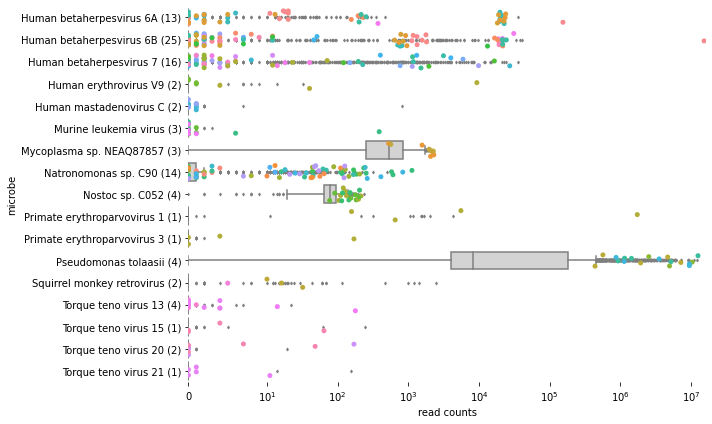

In [65]:
plt.figure(figsize=(10,6))
df_melt = df_melt.sort_values('microbe')
sns.boxplot(data=df_melt[df_melt.in_fam=='0'], x='read counts', y='microbe', color='#D3D3D3', fliersize=2)
sns.stripplot(data=df_melt[df_melt.in_fam!='0'], x='read counts', y='microbe', hue='in_fam', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_fam!='0'].in_fam.values))), jitter=.3)
abundance_plot_settings()
plt.savefig('%s/microbes_family_abundances.svg' % FIG_DIR, 
            transparent=True, bbox_inches='tight')
plt.savefig('%s/microbes_family_abundances.png' % FIG_DIR, 
            transparent=True, bbox_inches='tight', format='png', dpi=300)

# Bray Curtis Distances

# Pairwise distances

In [57]:
bc_microbe = squareform(pdist(df_microbe.drop(['family', 'sequencing_plate', 'bio_seq_source', 'sample'], axis=1), 'braycurtis'))
bc_microbe = pd.DataFrame(bc_microbe)

bc_microbe.columns = df_microbe.index
bc_microbe.index = df_microbe.index


/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/users/briannac/.local/lib/python3.6/site-packages/seaborn/matrix.py:630: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


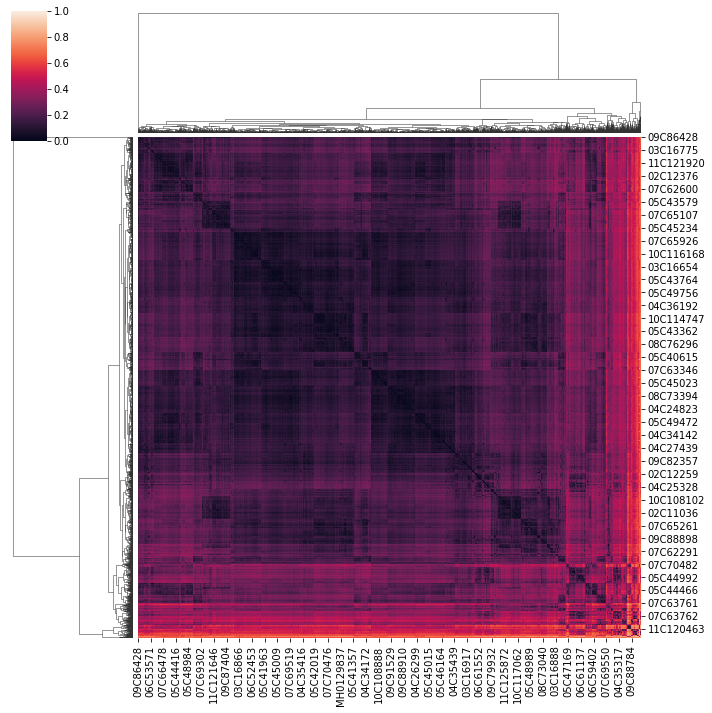

In [60]:
cm = sns.clustermap(bc_microbe)

# Bray-curtis distances: within family, sequencing plate, sample type.

In [ ]:
seq_plate_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_microbe.columns]['sequencing_plate']] for b in bam_mappings.loc[bc_microbe.columns]['sequencing_plate']])
bio_seq_source_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_microbe.columns]['bio_seq_source']] for b in bam_mappings.loc[bc_microbe.columns]['bio_seq_source']])
family_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_microbe.columns]['family']] for b in bam_mappings.loc[bc_microbe.columns]['family']])
bio_seq_source_WB = pd.DataFrame([[a=='WB' for a in bam_mappings.loc[bc_microbe.columns]['bio_seq_source']] for b in bam_mappings.loc[bc_microbe.columns]['bio_seq_source']])

In [69]:
idx = np.where(seq_plate_same * bio_seq_source_same * bio_seq_source_WB &(~family_same))
bc_microbe_same_seq_plate_WB  = [bc_microbe.loc[bc_microbe.index[i],bc_microbe.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where(seq_plate_same & bio_seq_source_same & (1-bio_seq_source_WB) & (~family_same))
bc_microbe_same_seq_plate_LCL  = [bc_microbe.loc[bc_microbe.index[i],bc_microbe.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-seq_plate_same) & bio_seq_source_same & bio_seq_source_WB & (~family_same))
bc_microbe_diff_seq_plate_WB  = [bc_microbe.loc[bc_microbe.index[i],bc_microbe.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-seq_plate_same) & bio_seq_source_same & (1-bio_seq_source_WB) & (~family_same))
bc_microbe_diff_seq_plate_LCL  = [bc_microbe.loc[bc_microbe.index[i],bc_microbe.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

Text(0, 0.5, 'Bray-Curtis distance')

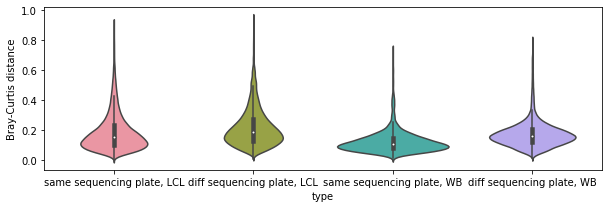

In [75]:
a = pd.DataFrame(bc_microbe_same_seq_plate_LCL)
a['type'] = 'same sequencing plate, LCL'

b = pd.DataFrame(bc_microbe_same_seq_plate_WB)
b['type'] = 'same sequencing plate, WB'

c = pd.DataFrame(bc_microbe_diff_seq_plate_LCL)
c['type'] = 'diff sequencing plate, LCL'

d = pd.DataFrame(bc_microbe_diff_seq_plate_WB)
d['type'] = 'diff sequencing plate, WB'

df = pd.concat([a,c,b,d])
plt.figure(figsize=(10,3))
sns.violinplot(data=df, x='type', y=0)
plt.ylabel('Bray-Curtis distance')

In [76]:
idx = np.where(family_same & bio_seq_source_same & seq_plate_same & bio_seq_source_WB)
bc_microbe_same_family_WB  = [bc_microbe.loc[bc_microbe.index[i],bc_microbe.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where(family_same & bio_seq_source_same & (1-bio_seq_source_WB) & seq_plate_same)
bc_microbe_same_family_LCL  = [bc_microbe.loc[bc_microbe.index[i],bc_microbe.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-family_same) & bio_seq_source_same & bio_seq_source_WB & seq_plate_same)
bc_microbe_diff_family_WB  = [bc_microbe.loc[bc_microbe.index[i],bc_microbe.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-family_same) & bio_seq_source_same & (1-bio_seq_source_WB) & seq_plate_same)
bc_microbe_diff_family_LCL  = [bc_microbe.loc[bc_microbe.index[i],bc_microbe.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

In [77]:
a = pd.DataFrame(bc_microbe_same_family_LCL)
a['type'] = 'same family, LCL'

b = pd.DataFrame(bc_microbe_same_family_WB)
b['type'] = 'same family, WB'

c = pd.DataFrame(bc_microbe_diff_family_LCL)
c['type'] = 'diff family, LCL'

d = pd.DataFrame(bc_microbe_diff_family_WB)
d['type'] = 'diff family, WB'

df = pd.concat([a,c,b,d])

Text(0, 0.5, 'Bray-Curtis distance')

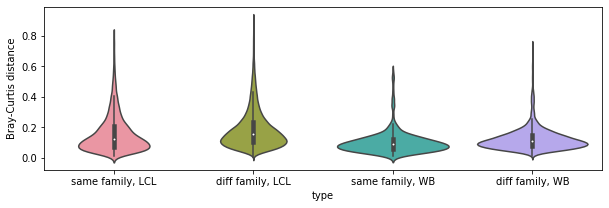

In [80]:
plt.figure(figsize=(10,3))
sns.violinplot(data=df, x='type', y=0)
plt.ylabel('Bray-Curtis distance')

# Virus

In [27]:
seq_plate_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_virus.columns]['sequencing_plate']] for b in bam_mappings.loc[bc_virus.columns]['sequencing_plate']])
bio_seq_source_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_virus.columns]['bio_seq_source']] for b in bam_mappings.loc[bc_virus.columns]['bio_seq_source']])
family_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_virus.columns]['family']] for b in bam_mappings.loc[bc_virus.columns]['family']])
bio_seq_source_WB = pd.DataFrame([[a=='WB' for a in bam_mappings.loc[bc_virus.columns]['bio_seq_source']] for b in bam_mappings.loc[bc_virus.columns]['bio_seq_source']])

In [28]:
idx = np.where(seq_plate_same * bio_seq_source_same * bio_seq_source_WB &(~family_same))
bc_virus_same_seq_plate_WB  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where(seq_plate_same * bio_seq_source_same * (1-bio_seq_source_WB) & (~family_same))
bc_virus_same_seq_plate_LCL  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-seq_plate_same) * bio_seq_source_same * bio_seq_source_WB & (~family_same))
bc_virus_diff_seq_plate_WB  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-seq_plate_same) * bio_seq_source_same * (1-bio_seq_source_WB) & (~family_same))
bc_virus_diff_seq_plate_LCL  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [29]:
a = pd.DataFrame(bc_virus_same_seq_plate_LCL)
a['type'] = 'same sequencing plate, LCL'

b = pd.DataFrame(bc_virus_same_seq_plate_WB)
b['type'] = 'same sequencing plate, WB'

c = pd.DataFrame(bc_virus_diff_seq_plate_LCL)
c['type'] = 'diff sequencing plate, LCL'

d = pd.DataFrame(bc_virus_diff_seq_plate_WB)
d['type'] = 'diff sequencing plate, WB'

df = pd.concat([a,b,c,d])
#sns.violinplot(data=df, x='type', y='0)

<AxesSubplot:xlabel='type', ylabel='0'>

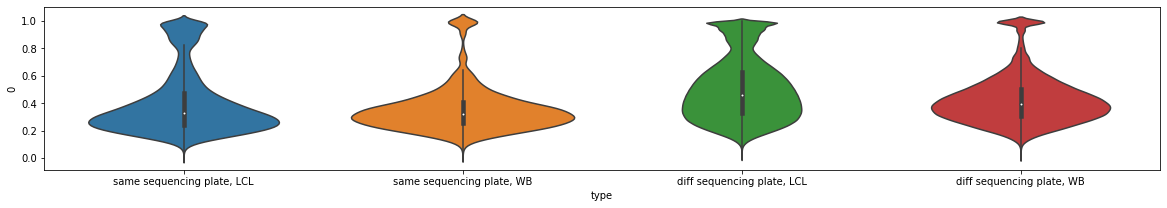

In [30]:
plt.figure(figsize=(20,3))
sns.violinplot(data=df, x='type', y=0)

In [31]:
idx = np.where(family_same & bio_seq_source_same & seq_plate_same & bio_seq_source_WB)
bc_virus_same_family_WB  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where(family_same & bio_seq_source_same & (1-bio_seq_source_WB) & seq_plate_same)
bc_virus_same_family_LCL  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-family_same) & bio_seq_source_same & bio_seq_source_WB & seq_plate_same)
bc_virus_diff_family_WB  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-family_same) & bio_seq_source_same & (1-bio_seq_source_WB) & seq_plate_same)
bc_virus_diff_family_LCL  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

In [32]:
a = pd.DataFrame(bc_virus_same_family_LCL)
a['type'] = 'same family, LCL'

b = pd.DataFrame(bc_virus_same_family_WB)
b['type'] = 'same family, WB'

c = pd.DataFrame(bc_virus_diff_family_LCL)
c['type'] = 'diff family, LCL'

d = pd.DataFrame(bc_virus_diff_family_WB)
d['type'] = 'diff family, WB'

df = pd.concat([a,b,c,d])

<AxesSubplot:xlabel='type', ylabel='0'>

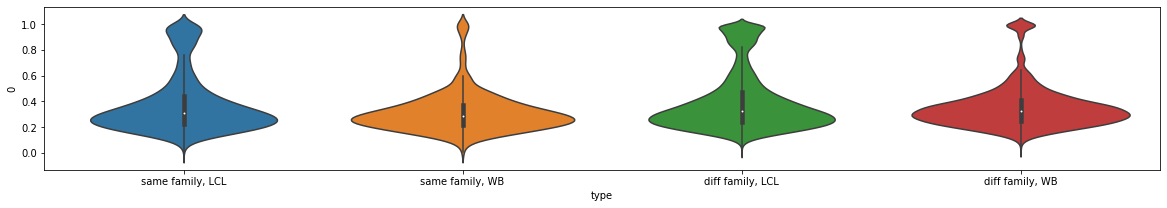

In [33]:
plt.figure(figsize=(20,3))
sns.violinplot(data=df, x='type', y=0)

# Virus

In [34]:
seq_plate_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_virus.columns]['sequencing_plate']] for b in bam_mappings.loc[bc_virus.columns]['sequencing_plate']])
bio_seq_source_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_virus.columns]['bio_seq_source']] for b in bam_mappings.loc[bc_virus.columns]['bio_seq_source']])
family_same = pd.DataFrame([[a==b for a in bam_mappings.loc[bc_virus.columns]['family']] for b in bam_mappings.loc[bc_virus.columns]['family']])
bio_seq_source_WB = pd.DataFrame([[a=='WB' for a in bam_mappings.loc[bc_virus.columns]['bio_seq_source']] for b in bam_mappings.loc[bc_virus.columns]['bio_seq_source']])

In [35]:
idx = np.wherefamilye_same * bio_seq_source_same * bio_seq_source_WB)
bc_virus_same_family_WB  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where(family_same * bio_seq_source_same * (1-bio_seq_source_WB))
bc_virus_same_family_LCL  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-family_same) * bio_seq_source_same * bio_seq_source_WB)
bc_virus_diff_family_WB  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

idx = np.where((1-family_same) * bio_seq_source_same * (1-bio_seq_source_WB))
bc_virus_diff_family_LCL  = [bc_virus.loc[bc_virus.index[i],bc_virus.columns[j]] for i,j in zip(idx[0], idx[1]) if i<j]

SyntaxError: invalid syntax (<ipython-input-35-7f5beff20159>, line 1)

In [4]:
df_virus['sequencing_plate'] = bam_mappings.loc[[i.split(' ')[0] for i in df_virus.index]].sequencing_plate.values
df_virus['family'] = bam_mappings.loc[[i.split(' ')[0] for i in df_virus.index]].family.values
df_virus['bio_seq_source'] = bam_mappings.loc[[i.split(' ')[0] for i in df_virus.index]].bio_seq_source.values

df_microbe['sequencing_plate'] = bam_mappings.loc[[i.split(' ')[0] for i in df_bacteria.index]].sequencing_plate.values
df_bacteria['family'] = bam_mappings.loc[[i.split(' ')[0] for i in df_bacteria.index]].family.values
df_bacteria['bio_seq_source'] = bam_mappings.loc[[i.split(' ')[0] for i in df_bacteria.index]].bio_seq_source.values


virus_pvals = pd.read_csv(virus_pvals_file, index_col=0)
bacteria_pvals = pd.read_csv(bacteria_pvals_file, index_col=0)

In [31]:
# Set up hits.
r, c = np.where(virus_pvals<(.05/(len(virus_pvals)+len(bacteria_pvals))))
hits = [(virus_pvals.index[i],virus_pvals.columns[j]) for i,j in zip(r,c)]
fam_hits = [h for h in hits if 'family' in h[1]]
fam_hits = [(i[0],i[1].replace('family_', '')) for i in fam_hits]


In [26]:
colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# Visualization of family associations.

## Virus

In [32]:
df_melt = pd.melt(df_virus[[f[0] for f in fam_hits] + ['family']].reset_index(), id_vars=['sample', 'family'])
df_melt['in_fam'] = '0'
for microbe,f in fam_hits:
    df_melt.loc[(df_melt.family==f) & (df_melt.variable==microbe),'in_fam']=f
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
n_families = Counter([h[0] for h in fam_hits])
df_melt['microbe'] = [m + ' (%i)' % n_families[m] for m in df_melt['microbe']]

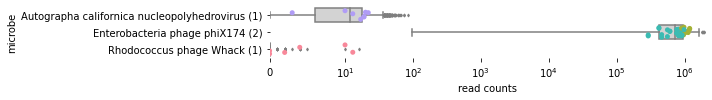

In [35]:
plt.figure(figsize=(10,1.5))
df_melt = df_melt.sort_values('microbe')
sns.boxplot(data=df_melt[df_melt.in_fam=='0'], x='read counts', y='microbe', color='#D3D3D3', fliersize=2)
sns.stripplot(data=df_melt[df_melt.in_fam!='0'], x='read counts', y='microbe', hue='in_fam', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_fam!='0'].in_fam.values))), jitter=.3)
abundance_plot_settings()
#plt.savefig('%s/virus_abundances.png' % fig_dir, 
#            transparent=True, bbox_inches='tight', format='png', dpi=500)

## Bacteria

In [52]:
interesting_fams = {f[1] for f in fam_hits}
Counter([f[1] for f in fam_hits]).most_common(10)

[('AU0906', 11),
 ('AU1696', 7),
 ('AU1047', 7),
 ('AU1371', 6),
 ('AU1951', 6),
 ('AU1789', 5),
 ('AU1932', 5),
 ('AU2052', 5),
 ('AU1072', 5),
 ('AU3348', 4)]

# Family associations in LCL?

In [85]:
fam_type = bam_mappings.groupby('family').aggregate(lambda x: Counter(x).most_common(1)[0][0])['bio_seq_source']
print(Counter(fam_type[list(interesting_fams)]))
print(Counter([f[1] for f in fam_hits]).most_common(10))

Counter({'LCL': 35, 'WB': 6})
[('AU0906', 11), ('AU1696', 7), ('AU1047', 7), ('AU1371', 6), ('AU1951', 6), ('AU1789', 5), ('AU1932', 5), ('AU2052', 5), ('AU1072', 5), ('AU3348', 4)]


In [80]:
Counter([(i[0], fam_type[i[1]]) for i in fam_hits])

Counter({('Acinetobacter baumannii AB058', 'LCL'): 5,
         ('Acinetobacter johnsonii SH046', 'LCL'): 10,
         ('Acinetobacter radioresistens SK82', 'LCL'): 3,
         ('Afipia 1NLS2', 'WB'): 2,
         ('Afipia 1NLS2', 'LCL'): 1,
         ('Bacillus cereus SJ1', 'LCL'): 1,
         ('Bradyrhizobium japonicum USDA', 'LCL'): 1,
         ('Bradyrhizobium ORS278', 'WB'): 2,
         ('Bradyrhizobium ORS278', 'LCL'): 1,
         ('Burkholderia CCGE1001', 'WB'): 1,
         ('Burkholderia Ch1-1', 'WB'): 1,
         ('Burkholderia graminis C4D1M', 'WB'): 1,
         ('Burkholderia H160', 'WB'): 2,
         ('Burkholderia pseudomallei S13', 'WB'): 1,
         ('Catenibacterium mitsuokai DSM_15897', 'LCL'): 1,
         ('Delftia acidovorans SPH-1', 'LCL'): 1,
         ('Escherichia coli MS_115-1', 'LCL'): 1,
         ('Escherichia coli MS_187-1', 'LCL'): 1,
         ('Leptothrix cholodnii SP-6', 'LCL'): 3,
         ('Methylibium petroleiphilum PM1', 'LCL'): 3,
         ('Methylobacter

# Set up.

In [19]:
# Load files
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)
df_virus = pd.read_csv(virus_file, index_col=0)
df_virus.columns = [c.replace('|', '') for c in df_virus.columns]
df_bacteria = pd.read_csv(bacteria_file, index_col=0)
df_virus['sequencing_plate'] = bam_mappings.loc[df_virus.index]['sequencing_plate']
df_virus['family'] = bam_mappings.loc[df_virus.index]['family']
df_virus['bio_seq_source'] = bam_mappings.loc[df_virus.index]['bio_seq_source']

df_bacteria['sequencing_plate'] = bam_mappings.loc[df_bacteria.index]['sequencing_plate']
df_bacteria['family'] = bam_mappings.loc[df_bacteria.index]['family']
df_bacteria['bio_seq_source'] = bam_mappings.loc[df_bacteria.index]['bio_seq_source']

# Filter known contaminants.
df_bacteria = df_bacteria.drop(['Fusobacterium ulcerans', 'Mollicutes bacterium D7'], axis=1)
df_virus = df_virus.drop(['Enterobacteria phage phiX174', 'Human herpesvirus 4'], axis=1)

df_bacteria_LCL = df_bacteria[df_bacteria['bio_seq_source']=='LCL'] 
df_bacteria_LCL = df_bacteria_LCL.drop(df_bacteria_LCL.columns[df_bacteria_LCL.sum()==0], axis=1)

df_bacteria_WB = df_bacteria[df_bacteria['bio_seq_source']=='WB']
df_bacteria_WB = df_bacteria_WB.drop(df_bacteria_WB.columns[df_bacteria_WB.sum()==0], axis=1)

# Filter to families in same batch/cell type
families_same_tech = df_virus[['family', 'bio_seq_source', 'sequencing_plate']].groupby('family').aggregate(lambda x: len(set(x)))
families_to_keep = list(families_same_tech[(families_same_tech['sequencing_plate']==1) & (families_same_tech['bio_seq_source']==1)].index)
df_virus = df_virus[[f in families_to_keep for f in df_virus.family]]

# Filter to families in same batch/cell type
families_same_tech = df_bacteria[['family', 'bio_seq_source', 'sequencing_plate']].groupby('family').aggregate(lambda x: len(set(x)))
families_to_keep = list(families_same_tech[(families_same_tech['sequencing_plate']==1) & (families_same_tech['bio_seq_source']==1)].index)
df_bacteria = df_bacteria[[f in families_to_keep for f in df_bacteria.family]]

families_same_tech = df_bacteria_LCL[['family', 'bio_seq_source', 'sequencing_plate']].groupby('family').aggregate(lambda x: len(set(x)))
families_to_keep = list(families_same_tech[(families_same_tech['sequencing_plate']==1) & (families_same_tech['bio_seq_source']==1)].index)
df_bacteria_LCL = df_bacteria_LCL[[f in families_to_keep for f in df_bacteria_LCL.family]]

families_same_tech = df_bacteria_WB[['family', 'bio_seq_source', 'sequencing_plate']].groupby('family').aggregate(lambda x: len(set(x)))
families_to_keep = list(families_same_tech[(families_same_tech['sequencing_plate']==1) & (families_same_tech['bio_seq_source']==1)].index)
df_bacteria_WB = df_bacteria_WB[[f in families_to_keep for f in df_bacteria_WB.family]]

In [20]:
# Set up family association computations.
# To find any outliers that might later influence contamination distribution.
def mannwhitneyu_with_fail_2_or_more_fams(x,y): 
    if len(x)<2: return np.nan
    if sum([xx>0 for xx in x])<2: return np.nan
    if len(set(y))==1: return 1
    return mannwhitneyu(x=x, y= list((Counter(y)-Counter(x)).elements()), alternative='greater').pvalue

# Family associations, with requirement that at least 2 members of family have microbe.
def mannwhitneyu_with_fail(x,y): 
    if len(set(y))==1: return np.nan
    if len(x)<2: return np.nan
    if sum([xx>0 for xx in x])<1: return np.nan # This line differs.
    if len(set(y))==1: return 1
    return mannwhitneyu(x=x, y= list((Counter(y)-Counter(x)).elements()), alternative='greater').pvalue

# Set up aggregation dataframes
df_virus_list_families = df_virus.groupby('family').aggregate(list)
df_virus_list_batches_types = df_virus.groupby(['sequencing_plate', 'bio_seq_source']).aggregate(list)
df_virus_most_common_batch_for_fam = df_virus[['sequencing_plate', 'family']].groupby('family').aggregate(lambda x: Counter(list(x)).most_common()[0][0])
df_virus_most_common_type_for_fam = df_virus[['bio_seq_source', 'family']].groupby('family').aggregate(lambda x: Counter(list(x)).most_common()[0][0])

# Similarity between family members & unrelated individuals

## Virus

In [21]:
fam_dists_WB = []
unrelated_dists_WB = []
fam_dists_LCL = []
unrelated_dists_LCL = []
for f in tqdm(df_virus_most_common_batch_for_fam.join(df_virus_most_common_type_for_fam).iterrows()):
    fam = f[0]
    sequencing_plate = f[1].sequencing_plate
    cell_type = f[1].bio_seq_source
    fams_microbe_vectors = df_virus[(df_virus['sequencing_plate']==sequencing_plate) & (df_virus['family']==fam) & (df_virus['bio_seq_source']==cell_type)].drop(
        ['sequencing_plate', 'family', 'bio_seq_source'], axis=1)
    unrelated_or_not = pdist(df_virus[(df_virus['sequencing_plate']==sequencing_plate) & (df_virus['bio_seq_source']==cell_type)][['family']], lambda u,v: u!=v)
    unrelated_microbe_vectors = df_virus[(df_virus['sequencing_plate']==sequencing_plate) & (df_virus['bio_seq_source']==cell_type)].drop(['sequencing_plate', 'family', 'bio_seq_source'], axis=1)
    unrelated_dist = unrelated_or_not * pdist(unrelated_microbe_vectors, 'braycurtis')
    unrelated_dist = unrelated_dist[unrelated_dist!=0]
    if cell_type=='WB':
        fam_dists_WB = fam_dists_WB + list(pdist(fams_microbe_vectors, 'braycurtis'))
        unrelated_dists_WB = unrelated_dists_WB + list(unrelated_dist)
    else:
        fam_dists_LCL = fam_dists_LCL + list(pdist(fams_microbe_vectors, 'braycurtis'))
        unrelated_dists_LCL = unrelated_dists_LCL + list(unrelated_dist)

     

In [27]:
for n,d in zip(['fam_LCL', 'unrel_LCL', 'fam_WB', 'unrelated_WB'],[fam_dists_LCL, unrelated_dists_LCL, fam_dists_WB, unrelated_dists_WB]):
    for nn,dd in zip(['fam_LCL', 'unrel_LCL', 'fam_WB', 'unrelated_WB'],[fam_dists_LCL, unrelated_dists_LCL, fam_dists_WB, unrelated_dists_WB]):
        if n <= nn: continue
        p=stats.mannwhitneyu(d, dd).pvalue
        if p<.05:
            print(n,nn, p)

unrel_LCL fam_LCL 3.973159900077795e-15
unrel_LCL fam_WB 1.6255862823402126e-20
fam_WB fam_LCL 7.700600721510558e-10
unrelated_WB fam_LCL 2.369059872918595e-09
unrelated_WB unrel_LCL 0.0
unrelated_WB fam_WB 6.530827547247895e-08


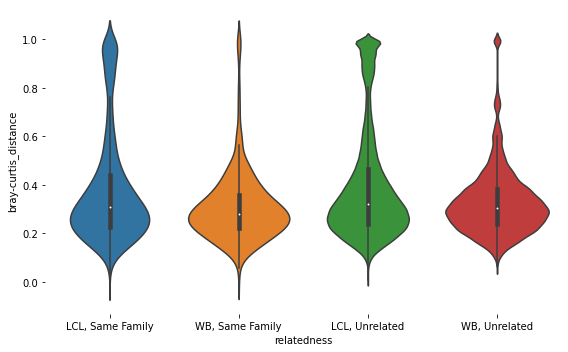

In [29]:
df1 = pd.DataFrame(fam_dists_LCL, columns=['bray-curtis_distance'])
df1['relatedness'] = 'LCL, Same Family'
df2 = pd.DataFrame(fam_dists_WB, columns=['bray-curtis_distance'])
df2['relatedness'] = 'WB, Same Family'
df3 = pd.DataFrame(unrelated_dists_LCL, columns=['bray-curtis_distance'])
df3['relatedness'] = 'LCL, Unrelated'
df4 = pd.DataFrame(unrelated_dists_WB, columns=['bray-curtis_distance'])
df4['relatedness'] = 'WB, Unrelated'
df = pd.concat([df1, df2, df3, df4])

plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='relatedness', y='bray-curtis_distance')
plt.tight_layout()
plt.box(on=None)
#plt.savefig('%s/virus_similarities.png' % fig_dir, 
#            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

In [35]:
{(i,j) for i,j in zip(df_virus.sequencing_plate), zip(df_virus.sequencing_plate)}

sample
02C10540     MTR-00927
02C10541     MTR-00927
02C10542     MTR-00927
02C10543     MTR-00927
02C10702     MTR-00010
               ...    
MH0143008    MTR-00027
MH0143009    MTR-00027
MH0143013    MTR-00027
MH0143018    MTR-00027
MH0143019    MTR-00027
Name: sequencing_plate, Length: 4120, dtype: object

In [48]:
dists = pdist(df_virus.drop(['sequencing_plate', 'family', 'bio_seq_source'], axis=1), 'braycurtis')

In [47]:
np.shape(ddists)

(8485140,)

In [44]:
seq_plate_dists_WB = []
unrelated_dists_WB = []
seq_plate_dists_LCL = []
unrelated_dists_LCL = []
for sequencing_plate, cell_type in tqdm(list({(i,j) for i,j in zip(df_virus.sequencing_plate, df_virus.bio_seq_source)})):
    seq_plates_microbe_vectors = df_virus[(df_virus['sequencing_plate']==sequencing_plate) & (df_virus['bio_seq_source']==cell_type)].drop(
        ['sequencing_plate', 'family', 'bio_seq_source'], axis=1)
    unrelated_or_not = pdist(df_virus[(df_virus['sequencing_plate']!=sequencing_plate) & (df_virus['bio_seq_source']==cell_type)][['family']], lambda u,v: u!=v)
    unrelated_microbe_vectors = df_virus[(df_virus['sequencing_plate']!=sequencing_plate) & (df_virus['bio_seq_source']==cell_type)].drop(['sequencing_plate', 'family', 'bio_seq_source'], axis=1)
    unrelated_dist = unrelated_or_not * pdist(unrelated_microbe_vectors, 'braycurtis')
    unrelated_dist = unrelated_dist[unrelated_dist!=0]
    if cell_type=='WB':
        seq_plate_dists_WB = seq_plate_dists_WB + list(pdist(seq_plates_microbe_vectors, 'braycurtis'))
        unrelated_dists_WB = unrelated_dists_WB + list(unrelated_dist)
    else:
        seq_plate_dists_LCL = seq_plate_dists_LCL + list(pdist(seq_plates_microbe_vectors, 'braycurtis'))
        unrelated_dists_LCL = unrelated_dists_LCL + list(unrelated_dist)

     

  0%|          | 0/73 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
for n,d in zip(['fam_LCL', 'unrel_LCL', 'fam_WB', 'unrelated_WB'],[fam_dists_LCL, unrelated_dists_LCL, fam_dists_WB, unrelated_dists_WB]):
    for nn,dd in zip(['fam_LCL', 'unrel_LCL', 'fam_WB', 'unrelated_WB'],[fam_dists_LCL, unrelated_dists_LCL, fam_dists_WB, unrelated_dists_WB]):
        if n <= nn: continue
        p=stats.mannwhitneyu(d, dd).pvalue
        if p<.05:
            print(n,nn, p)

unrel_LCL fam_LCL 0.0
unrel_LCL fam_WB 5.855278839010213e-215
fam_WB fam_LCL 1.4346860708255683e-05
unrelated_WB fam_LCL 0.0
unrelated_WB unrel_LCL 2.4696204856490304e-32
unrelated_WB fam_WB 1.919539616056767e-186


In [ ]:
df1 = pd.DataFrame(fam_dists_LCL, columns=['bray-curtis_distance'])
df1['relatedness'] = 'LCL, Same Family'
df2 = pd.DataFrame(fam_dists_WB, columns=['bray-curtis_distance'])
df2['relatedness'] = 'WB, Same Family'
df3 = pd.DataFrame(unrelated_dists_LCL, columns=['bray-curtis_distance'])
df3['relatedness'] = 'LCL, Unrelated'
df4 = pd.DataFrame(unrelated_dists_WB, columns=['bray-curtis_distance'])
df4['relatedness'] = 'WB, Unrelated'
df = pd.concat([df1, df2, df3, df4])

plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='relatedness', y='bray-curtis_distance')
plt.tight_layout()
plt.box(on=None)
#plt.savefig('%s/virus_similarities.png' % fig_dir, 
#            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

## Bacteria

In [30]:
fam_dists_WB = []
unrelated_dists_WB = []
fam_dists_LCL = []
unrelated_dists_LCL = []
for f in tqdm(df_virus_most_common_batch_for_fam.join(df_virus_most_common_type_for_fam).iterrows()):
    fam = f[0]
    sequencing_plate = f[1].sequencing_plate
    cell_type = f[1].bio_seq_source
    fams_microbe_vectors = df_bacteria[(df_bacteria['sequencing_plate']==sequencing_plate) & (df_bacteria['family']==fam) & (df_bacteria['bio_seq_source']==cell_type)].drop(
        ['sequencing_plate', 'family', 'bio_seq_source'], axis=1)
    unrelated_or_not = pdist(df_bacteria[(df_bacteria['sequencing_plate']==sequencing_plate) & (df_bacteria['bio_seq_source']==cell_type)][['family']], lambda u,v: u!=v)
    unrelated_microbe_vectors = df_bacteria[(df_bacteria['sequencing_plate']==sequencing_plate) & (df_bacteria['bio_seq_source']==cell_type)].drop(['sequencing_plate', 'family', 'bio_seq_source'], axis=1)
    unrelated_dist = unrelated_or_not * pdist(unrelated_microbe_vectors, 'braycurtis')
    unrelated_dist = unrelated_dist[unrelated_dist!=0]
    if cell_type=='WB':
        fam_dists_WB = fam_dists_WB + list(pdist(fams_microbe_vectors, 'braycurtis'))
        unrelated_dists_WB = unrelated_dists_WB + list(unrelated_dist)
    else:
        fam_dists_LCL = fam_dists_LCL + list(pdist(fams_microbe_vectors, 'braycurtis'))
        unrelated_dists_LCL = unrelated_dists_LCL + list(unrelated_dist)

     

916it [00:31, 29.41it/s]


In [32]:
for n,d in zip(['fam_LCL', 'unrel_LCL', 'fam_WB', 'unrelated_WB'],[fam_dists_LCL, unrelated_dists_LCL, fam_dists_WB, unrelated_dists_WB]):
    for nn,dd in zip(['fam_LCL', 'unrel_LCL', 'fam_WB', 'unrelated_WB'],[fam_dists_LCL, unrelated_dists_LCL, fam_dists_WB, unrelated_dists_WB]):
        if n <= nn: continue
        p=stats.mannwhitneyu(d, dd).pvalue
        if p<.05:
            print(n,nn, p)

unrel_LCL fam_LCL 3.745240169903354e-251
unrel_LCL fam_WB 2.671181012435251e-48
fam_WB fam_LCL 1.8350069152672624e-05
unrelated_WB fam_LCL 0.0
unrelated_WB unrel_LCL 1.5982139409236613e-289
unrelated_WB fam_WB 1.2303554501474969e-86


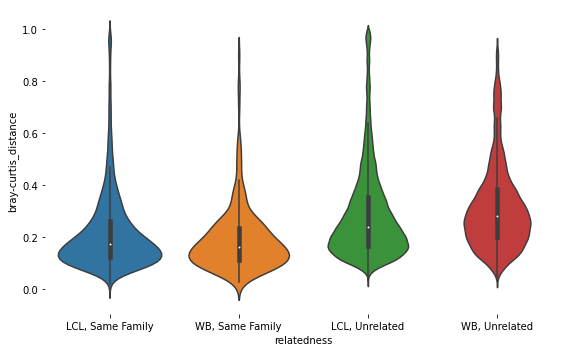

In [34]:
df1 = pd.DataFrame(fam_dists_LCL, columns=['bray-curtis_distance'])
df1['relatedness'] = 'LCL, Same Family'
df2 = pd.DataFrame(fam_dists_WB, columns=['bray-curtis_distance'])
df2['relatedness'] = 'WB, Same Family'
df3 = pd.DataFrame(unrelated_dists_LCL, columns=['bray-curtis_distance'])
df3['relatedness'] = 'LCL, Unrelated'
df4 = pd.DataFrame(unrelated_dists_WB, columns=['bray-curtis_distance'])
df4['relatedness'] = 'WB, Unrelated'
df = pd.concat([df1, df2, df3, df4])

plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='relatedness', y='bray-curtis_distance')
plt.tight_layout()
plt.box(on=None)
#plt.savefig('%s/virus_similarities.png' % fig_dir, 
#            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

In [ ]:
# Family-associated microbes, limiting to families/microbes where microbe appears in at least one family member.
# We will use for graph.

# Set up aggregation dataframes
virus_pvals=[]
for f in tqdm(df_virus_most_common_type_for_fam.join(df_bacteria_most_common_batch_for_fam).iterrows()):
    fam = f[0]
    batch = f[1].batch
    cell_type = f[1].type
    virus_pvals= virus_pvals + [(fam,col,mannwhitneyu_with_fail_2_or_more_fams(fam_list, batch_list)) for col, fam_list, batch_list in 
                                zip(df_virus_list_families.columns[:-2], 
                                    df_virus_list_families.loc[fam].values[:-2], 
                                    df_bacteria_list_batches_types.loc[(batch, cell_type)].values[:-2])]
virus_pvals_na = np.array([i[2] for i in virus_pvals])
virus_pvals_na = virus_pvals_na[~np.isnan(virus_pvals_na)]


# Hits
hits = [i for i in virus_pvals if i[2]<(.05/len(virus_pvals_na))]
hit_microbes = list(set([h[1] for h in hits]))
print(len(hits))
print(len(hit_microbes))

^ Note that the "bump" corresponds to high herpes 6B / 7 samples vs no herpes 6B/7.

In [185]:
# All 'family'-associated microbes, including those with just one member of family with virus. 
# We will use saved values for contaminant computation later on.
virus_pvals=[]
for f in tqdm(df_virus_most_common_type_for_fam.join(df_bacteria_most_common_batch_for_fam).iterrows()):
    fam = f[0]
    batch = f[1].batch
    cell_type = f[1].type
    virus_pvals= virus_pvals + [(fam,col,mannwhitneyu_with_fail(fam_list, batch_list)) for col, fam_list, batch_list in 
                                zip(df_virus_list_families.columns[:-2], 
                                    df_virus_list_families.loc[fam].values[:-2], 
                                    df_bacteria_list_batches_types.loc[(batch, cell_type)].values[:-2])]
virus_pvals_na = np.array([i[2] for i in virus_pvals])
virus_pvals_na = virus_pvals_na[~np.isnan(virus_pvals_na)]

hits = [i for i in virus_pvals if i[2]<(.05/len(virus_pvals_na))]
hit_microbes = list(set([h[1] for h in hits]))
print(len(hits))
print(len(hit_microbes))

# Save hits to results directory (to be used in contaminant computation)
pd.DataFrame(hits, columns=['family', 'microbe', 'p']).drop('p', axis=1).to_csv('%s/virus_family_hits.csv' % results_dir)


0it [00:00, ?it/s]


KeyError: nan

## Compute and visualize hits

# Bacteria -- all.

In [ ]:
df_bacteria_list_families = df_bacteria.groupby('family').aggregate(list)
df_bacteria_list_batches_types = df_bacteria.groupby(['batch', 'type']).aggregate(list)
df_bacteria_most_common_batch_for_fam = df_bacteria[['batch', 'family']].groupby('family').aggregate(lambda x: Counter(list(x)).most_common()[0][0])
df_bacteria_most_common_type_for_fam = df_bacteria[['type', 'family']].groupby('family').aggregate(lambda x: Counter(list(x)).most_common()[0][0])

In [ ]:
# All 'family'-associated microbes, including those with just one member of family with virus. 
# We will use saved values for contaminant computation later on.
bacteria_pvals = []
for f in tqdm(df_bacteria_most_common_type_for_fam.join(df_bacteria_most_common_batch_for_fam).iterrows()):
    fam = f[0]
    batch = f[1].batch
    cell_type = f[1].type
    bacteria_pvals = bacteria_pvals + [(fam,col,mannwhitneyu_with_fail(fam_list, batch_list)) for col, fam_list, batch_list in 
                                zip(df_bacteria_list_families.columns[:-2], 
                                    df_bacteria_list_families.loc[fam].values[:-2], 
                                    df_bacteria_list_batches_types.loc[(batch, cell_type)].values[:-2])]
bacteria_pvals_na = np.array([i[2] for i in bacteria_pvals])
bacteria_pvals_na = bacteria_pvals_na[~np.isnan(bacteria_pvals_na)]

# Hits
hits = [i for i in bacteria_pvals if i[2]<(.05/len(bacteria_pvals_na))]
hit_microbes = list(set([h[1] for h in hits]))
print(len(hits))
print(len(hit_microbes))
pd.DataFrame(hits, columns=['family', 'microbe', 'p']).drop('p', axis=1).to_csv('%s/bacteria_family_hits.csv' % results_dir)

# Similarity

In [ ]:
fam_dists_WB = []
unrelated_dists_WB = []
fam_dists_LCL = []
unrelated_dists_LCL = []
for f in (df_bacteria_most_common_type_for_fam.join(df_bacteria_most_common_batch_for_fam).iterrows()):
    fam = f[0]
    batch = f[1].batch
    cell_type = f[1].type
    fams_microbe_vectors = df_bacteria[(df_bacteria['batch']==batch) & (df_bacteria['family']==fam) & (df_bacteria['type']==cell_type)].drop(
        ['batch', 'family', 'type'], axis=1)
    unrelated_or_not = pdist(df_bacteria[(df_bacteria['batch']==batch) & (df_bacteria['type']==cell_type)][['family']], lambda u,v: u!=v)
    unrelated_microbe_vectors = df_bacteria[(df_bacteria['batch']==batch) & (df_bacteria['type']==cell_type)].drop(['batch', 'family', 'type'], axis=1)
    unrelated_dist = unrelated_or_not * pdist(unrelated_microbe_vectors, 'braycurtis')
    unrelated_dist = unrelated_dist[unrelated_dist!=0]
    if cell_type=='WB':
        fam_dists_WB = fam_dists_WB + list(pdist(fams_microbe_vectors, 'braycurtis'))
        unrelated_dists_WB = unrelated_dists_WB + list(unrelated_dist)
    else:
        fam_dists_LCL = fam_dists_LCL + list(pdist(fams_microbe_vectors, 'braycurtis'))
        unrelated_dists_LCL = unrelated_dists_LCL + list(unrelated_dist)

        
for n,d in zip(['fam_LCL', 'unrel_LCL', 'fam_WB', 'unrelated_WB'],[fam_dists_LCL, unrelated_dists_LCL, fam_dists_WB, unrelated_dists_WB]):
    for nn,dd in zip(['fam_LCL', 'unrel_LCL', 'fam_WB', 'unrelated_WB'],[fam_dists_LCL, unrelated_dists_LCL, fam_dists_WB, unrelated_dists_WB]):
        if n <= nn: continue
        p=mannwhitneyu(d, dd).pvalue
        if p<.05:
            print(n,nn, p)
df1 = pd.DataFrame(fam_dists_LCL, columns=['bray-curtis_distance'])
df1['relatedness'] = 'Same Family_LCL'
df2 = pd.DataFrame(unrelated_dists_LCL, columns=['bray-curtis_distance'])
df2['relatedness'] = 'Unrelated_LCL'
df3 = pd.DataFrame(fam_dists_WB, columns=['bray-curtis_distance'])
df3['relatedness'] = 'Same Family_WB'
df4 = pd.DataFrame(unrelated_dists_WB, columns=['bray-curtis_distance'])
df4['relatedness'] = 'Unrelated_WB'
df = pd.concat([df1, df2, df3, df4])

In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='relatedness', y='bray-curtis_distance')
plt.tight_layout()
plt.box(on=None)
plt.savefig('%s/bacteria_similarities.png' % fig_dir, 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

# Bacteria LCL 

In [ ]:
df_bacteria = df_bacteria_LCL
df_bacteria_list_families = df_bacteria.groupby('family').aggregate(list)
df_bacteria_list_batches_types = df_bacteria.groupby(['batch', 'type']).aggregate(list)
df_bacteria_most_common_batch_for_fam = df_bacteria[['batch', 'family']].groupby('family').aggregate(lambda x: Counter(list(x)).most_common()[0][0])
df_bacteria_most_common_type_for_fam = df_bacteria[['type', 'family']].groupby('family').aggregate(lambda x: Counter(list(x)).most_common()[0][0])

In [ ]:
# Family-associated microbes, limiting to families/microbes where microbe appears in at least one family member.
# We will use for graph.
bacteria_pvals=[]
for f in tqdm(df_bacteria_most_common_type_for_fam.join(df_bacteria_most_common_batch_for_fam).iterrows()):
    fam = f[0]
    batch = f[1].batch
    cell_type = f[1].type
    bacteria_pvals= bacteria_pvals + [(fam,col,mannwhitneyu_with_fail_2_or_more_fams(fam_list, batch_list)) for col, fam_list, batch_list in 
                                zip(df_bacteria_list_families.columns[:-2], 
                                    df_bacteria_list_families.loc[fam].values[:-2], 
                                    df_bacteria_list_batches_types.loc[(batch, cell_type)].values[:-2])]
bacteria_pvals_na = np.array([i[2] for i in bacteria_pvals])
bacteria_pvals_na = bacteria_pvals_na[~np.isnan(bacteria_pvals_na)]

In [ ]:
# Top hits (for graph)
hits = [i for i in bacteria_pvals if i[2]<(.05/len(bacteria_pvals_na))]
print(len(hits)) 
print(len(list(set([h[1] for h in hits]))))
hits = sorted(hits, key=lambda x: x[2])[:100]
hit_microbes = list(set([h[1] for h in hits]))
#hits=[i for i in bacteria_pvals if ((i[2]<(.05/len(bacteria_pvals))) & (i[1] in hit_microbes))]
print(len(hits))
print(len(hit_microbes))

In [ ]:
df_melt = pd.melt(df_bacteria[hit_microbes + ['batch', 'family', 'type']].reset_index(), id_vars=['type','index', 'family', 'batch'])
df_melt['in_fam'] = '0'
for f,microbe,_ in hits:
    df_melt.loc[(df_melt.family==f) & (df_melt.variable==microbe),'in_fam']=f
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
n_families = Counter([h[1] for h in hits])
keep_batch_microbes = df_melt.groupby(['batch', 'microbe']).aggregate(lambda x: len(set(x)))
keep_batch_microbes = keep_batch_microbes.reset_index()
keep_batch_microbes = keep_batch_microbes[keep_batch_microbes.in_fam>1]
to_keep = {(i,j) for i,j in zip(keep_batch_microbes['batch'].values, keep_batch_microbes['microbe'].values)}
df_melt = df_melt[[(i,j) in to_keep for i,j in zip(df_melt.batch, df_melt.microbe)]]

In [ ]:
plt.figure(figsize=(10,20))
df_melt = df_melt.sort_values('microbe')
sns.boxplot(data=df_melt[df_melt.in_fam=='0'], x='read counts', y='microbe', color='#D3D3D3', fliersize=2)
sns.stripplot(data=df_melt[df_melt.in_fam!='0'], x='read counts', y='microbe', hue='in_fam', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_fam!='0'].in_fam.values))), jitter=.2)
abundance_plot_settings()
plt.savefig('%s/bacteria_abundances_LCL.png' % (fig_dir), 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

# WB

In [ ]:
df_bacteria = df_bacteria_WB
df_bacteria_list_families = df_bacteria.groupby('family').aggregate(list)
df_bacteria_list_batches_types = df_bacteria.groupby(['batch', 'type']).aggregate(list)
df_bacteria_most_common_batch_for_fam = df_bacteria[['batch', 'family']].groupby('family').aggregate(lambda x: Counter(list(x)).most_common()[0][0])
df_bacteria_most_common_type_for_fam = df_bacteria[['type', 'family']].groupby('family').aggregate(lambda x: Counter(list(x)).most_common()[0][0])

In [ ]:
# Family-associated microbes, limiting to families/microbes where microbe appears in at least one family member.
# We will use for graph.
bacteria_pvals=[]
for f in tqdm(df_bacteria_most_common_type_for_fam.join(df_bacteria_most_common_batch_for_fam).iterrows()):
    fam = f[0]
    batch = f[1].batch
    cell_type = f[1].type
    bacteria_pvals= bacteria_pvals + [(fam,col,mannwhitneyu_with_fail_2_or_more_fams(fam_list, batch_list)) for col, fam_list, batch_list in 
                                zip(df_bacteria_list_families.columns[:-2], 
                                    df_bacteria_list_families.loc[fam].values[:-2], 
                                    df_bacteria_list_batches_types.loc[(batch, cell_type)].values[:-2])]
bacteria_pvals_na = np.array([i[2] for i in bacteria_pvals])
bacteria_pvals_na = bacteria_pvals_na[~np.isnan(bacteria_pvals_na)]


# Top hits (for graph)
hits = [i for i in bacteria_pvals if i[2]<(.05/len(bacteria_pvals_na))]
hit_microbes = list(set([h[1] for h in hits]))
#hits=[i for i in bacteria_pvals if ((i[2]<(.05/len(bacteria_pvals))) & (i[1] in hit_microbes))]
print(len(hit_microbes))
print(len(hits))

In [ ]:
df_melt = pd.melt(df_bacteria[hit_microbes + ['batch', 'family', 'type']].reset_index(), id_vars=['type','index', 'family', 'batch'])
df_melt['in_fam'] = '0'
for f,microbe,_ in tqdm(hits):
    df_melt.loc[(df_melt.family==f) & (df_melt.variable==microbe),'in_fam']=f
df_melt.rename(columns={'variable': 'microbe', 'value': 'read counts'}, inplace=True)
n_families = Counter([h[1] for h in hits])
keep_batch_microbes = df_melt.groupby(['batch', 'microbe']).aggregate(lambda x: len(set(x)))
keep_batch_microbes = keep_batch_microbes.reset_index()
keep_batch_microbes = keep_batch_microbes[keep_batch_microbes.in_fam>1]
to_keep = {(i,j) for i,j in zip(keep_batch_microbes['batch'].values, keep_batch_microbes['microbe'].values)}
df_melt = df_melt[[(i,j) in to_keep for i,j in zip(df_melt.batch, df_melt.microbe)]]

In [ ]:
plt.figure(figsize=(10,20))
df_melt = df_melt.sort_values('microbe')
sns.boxplot(data=df_melt[df_melt.in_fam=='0'], x='read counts', y='microbe', color='#D3D3D3', fliersize=2)
sns.stripplot(data=df_melt[df_melt.in_fam!='0'], x='read counts', y='microbe', hue='in_fam', 
              hue_order = sorted(list(np.unique(df_melt[df_melt.in_fam!='0'].in_fam.values))), jitter=.2)
abundance_plot_settings()
plt.savefig('%s/bacteria_abundances_WB.png' % (fig_dir), 
            transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()